In [1]:
import tensorflow as tf
import pathlib
import gzip
import shutil
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from tensorflow.keras import layers, models
from  sklearn.model_selection import train_test_split

c:\Users\Cr0l3y\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
dado_audio = "dataset_commands-002.gz"

In [3]:
dado_audio = "dataset_commands-002.gz" 
def le_arquivos(dado_audio):
    extracted_path = "dataset_commands-002" 
    if not pathlib.Path(dado_audio).exists():
        raise FileNotFoundError(f"Arquivo '{dado_audio}' não encontrado!")
    tar_path = extracted_path + ".tar"
    with gzip.open(dado_audio, "rb") as f_in:
        with open(tar_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    shutil.unpack_archive(tar_path, extracted_path)
    data_dir = pathlib.Path(extracted_path)
    all_audio_paths = list(data_dir.glob("**/*.wav")) 
    all_labels = [path.parent.name for path in all_audio_paths]  
    all_audio_paths = [str(path) for path in all_audio_paths]
    return all_audio_paths, all_labels

all_audio_paths, all_labels = le_arquivos(dado_audio)
print(f"Total de arquivos de áudio encontrados: {len(all_audio_paths)}")
print(f"Primeiros arquivos: {all_audio_paths[:5]}")
print(f"Primeiros rótulos: {all_labels[:5]}")

Total de arquivos de áudio encontrados: 105835
Primeiros arquivos: ['dataset_commands-002\\backward\\0165e0e8_nohash_0.wav', 'dataset_commands-002\\backward\\017c4098_nohash_0.wav', 'dataset_commands-002\\backward\\017c4098_nohash_1.wav', 'dataset_commands-002\\backward\\017c4098_nohash_2.wav', 'dataset_commands-002\\backward\\017c4098_nohash_3.wav']
Primeiros rótulos: ['backward', 'backward', 'backward', 'backward', 'backward']


In [ ]:
np.unique(all_labels)

In [5]:
audio_example = all_audio_paths[0]

In [6]:
audio_binary = tf.io.read_file(audio_example)
audio, _ = tf.audio.decode_wav(audio_binary)
audio = tf.squeeze(audio, axis=1)

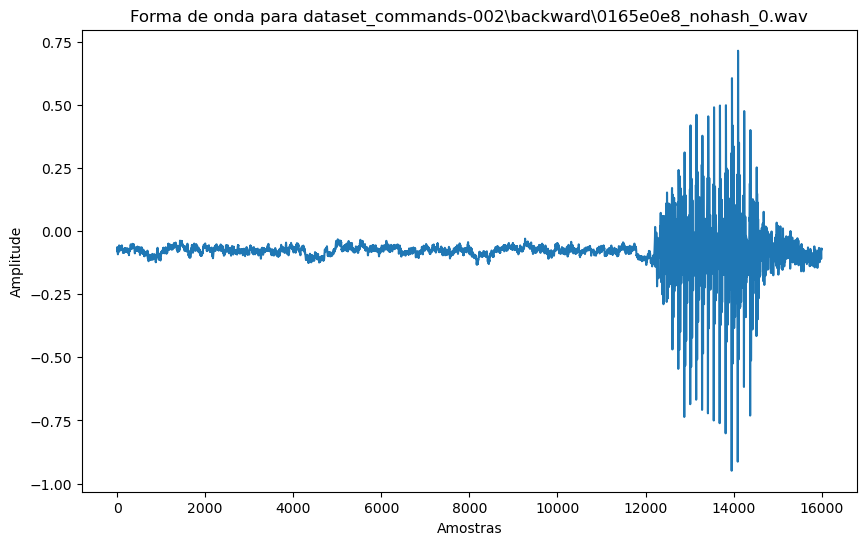

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {audio_example}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

In [8]:
def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    def scipy_resample(wav, sample_rate):
        if sample_rate !=16000:
            wav = resample(wav, int(16000/ sample_rate *len(wav)))
        return wav
    
    wav = tf.py_function(scipy_resample,[wav,sample_rate], tf.float32)

    
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        padding = [[0, pad_length]]
        wav = tf.pad(wav, padding, "CONSTANT")

    return tf.reshape(wav, [max_length])

def process_path(file_path,label):
    audio= load_and_process_audio(file_path)
    return audio, label

def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds= tf.data.Dataset.from_tensor_slices(labels)
    audio_label_ds= tf.data.Dataset.zip((path_ds,label_ds))
    return audio_label_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
def pre_training(ds, bath_size= 32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(bath_size)
    ds = ds.prefetch(buffer_size= tf.data.AUTOTUNE)
    return ds

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encore  = LabelEncoder()
all_labels_encoded = label_encore.fit_transform(all_labels)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_audio_paths, all_labels_encoded, test_size=0.02, random_state=42, stratify=all_labels_encoded)

train_dataset = paths_and_labels_to_dataset(train_paths, train_labels)
test_dataset = paths_and_labels_to_dataset(val_paths, val_labels)
train_dataset = pre_training(train_dataset)
test_dataset = pre_training(test_dataset) 

def espectrograma(formadeonda):
    espect = tf.signal.stft(formadeonda, frame_length=255, frame_step=128) 
    espect = tf.abs(espect) 
    espect = espect[..., tf.newaxis] 
    return espect

espect = espectrograma(audio.numpy())

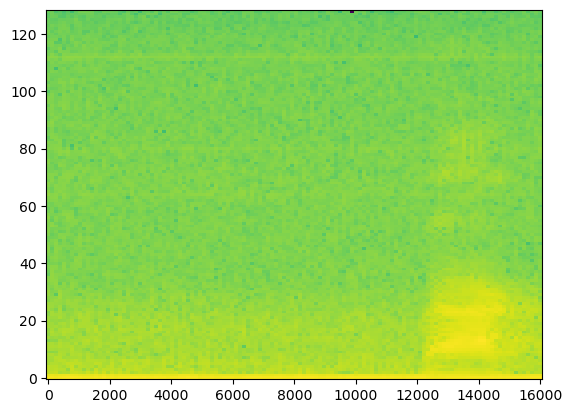

In [ ]:
def plota_espectrograma(espectrograma):
    if len(espectrograma.shape) > 2:
        assert len(espectrograma.shape) == 3
        espectrograma = np.squeeze(espectrograma, axis=-1)
                
    log_spec = np.log(espectrograma.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]

    X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
    Y = range(height)
    plt.pcolormesh(X, Y, log_spec)
    
plota_espectrograma(espect)

In [ ]:
def get_espectrograma_label (audio, label):
    espect = espectrograma(audio)
    return espect, label

train_spec = train_dataset.map(map_func=get_espectrograma_label, num_parallel_calls=tf.data.AUTOTUNE)
test_spec = test_dataset.map(map_func=get_espectrograma_label, num_parallel_calls=tf.data.AUTOTUNE)

norm_layer = tf.keras.layers.Normalization()
for spectrogram, _ in train_spec.take(1):          
    norm_layer.adapt(spectrogram)
    input_shape = spectrogram.shape[1:]

num_labels = len(np.unique(all_labels))
input_shape

TensorShape([124, 129, 1])

In [ ]:
#sequencia de camadas
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32,3, activation="relu"),
    layers.Conv2D(64,3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation="softmax")
])

model_spectrogram.compile(optimizer="adam",
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])

In [33]:
history_spectrogram = model_spectrogram.fit(train_spec, epochs=10, validation_data=test_spec)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 109s 33ms/step - accuracy: 0.3576 - loss: 2.2989 - val_accuracy: 0.7553 - val_loss: 0.8962
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 75s 23ms/step - accuracy: 0.6623 - loss: 1.1552 - val_accuracy: 0.7997 - val_loss: 0.6801
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - accuracy: 0.7168 - loss: 0.9529 - val_accuracy: 0.8257 - val_loss: 0.6110
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 75s 23ms/step - accuracy: 0.7433 - loss: 0.8505 - val_accuracy: 0.8408 - val_loss: 0.5591
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - accuracy: 0.7666 - loss: 0.7778 - val_accuracy: 0.8517 - val_loss: 0.5284
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - accuracy: 0.7816 - loss: 0.7246 - val_accuracy: 0.8503 - val_loss: 0.5148
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - accuracy: 0.7925 - loss: 0.6765 - val_accuracy: 0.8588 - val_loss: 0.4968
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - accuracy: 0.7994 

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

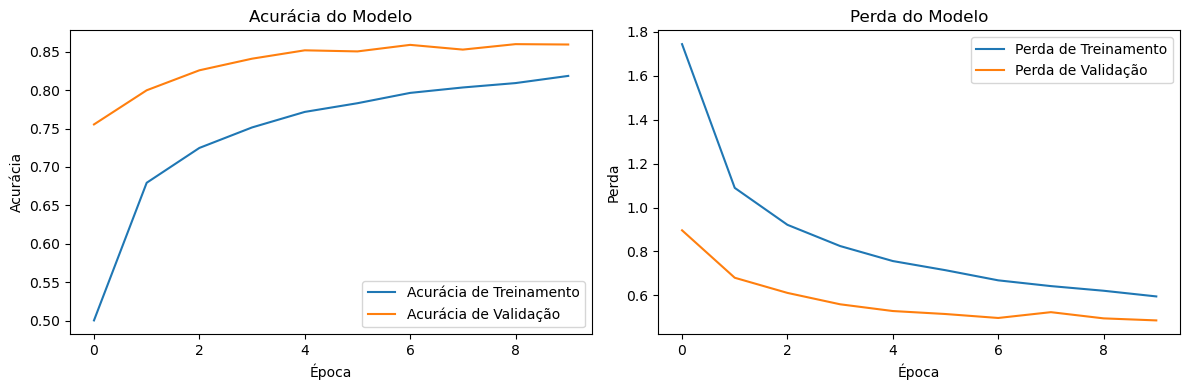

In [38]:
plot_history(history_spectrogram)

In [ ]:
class ChannelAttention(tf.keras.layers.Layer): 
    def __init__(self, ratio=8, **kwargs):
        super().__init__(**kwargs)  
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
       
        self.fc1 = layers.Dense(units=ratio, activation="relu")  
        self.fc2 = layers.Dense(units=1, activation="sigmoid")  
    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)

        avg_out = self.fc1(avg_out) 
        max_out = self.fc1(max_out)

        avg_out = self.fc2(avg_out) 
        max_out = self.fc2(max_out)

        out = avg_out + max_out
        out = tf.expand_dims(tf.expand_dims(out, axis=1), axis=1)
        out = tf.broadcast_to(out, tf.shape(inputs))  
        
        return inputs * out  

In [ ]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32,3, activation="relu"),
    ChannelAttention(ratio=8),  
    layers.Conv2D(64,3, activation="relu"),
    ChannelAttention(ratio=8),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation="softmax")
])

model_spectrogram.compile(optimizer="adam",
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])

In [ ]:
history_spectrogram = model_spectrogram.fit(train_spec, epochs=10, validation_data=test_spec)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 111s 34ms/step - accuracy: 0.3390 - loss: 2.3553 - val_accuracy: 0.7355 - val_loss: 0.8920
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 110s 34ms/step - accuracy: 0.6444 - loss: 1.1884 - val_accuracy: 0.7879 - val_loss: 0.7107
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.7048 - loss: 0.9776 - val_accuracy: 0.8219 - val_loss: 0.6128
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 106s 33ms/step - accuracy: 0.7412 - loss: 0.8601 - val_accuracy: 0.8314 - val_loss: 0.5554
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 105s 32ms/step - accuracy: 0.7594 - loss: 0.7871 - val_accuracy: 0.8455 - val_loss: 0.5197
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 102s 31ms/step - accuracy: 0.7773 - loss: 0.7287 - val_accuracy: 0.8540 - val_loss: 0.5005
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 104s 32ms/step - accuracy: 0.7892 - loss: 0.6828 - val_accuracy: 0.8540 - val_loss: 0.4932
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 110s 34ms/step - accuracy: 

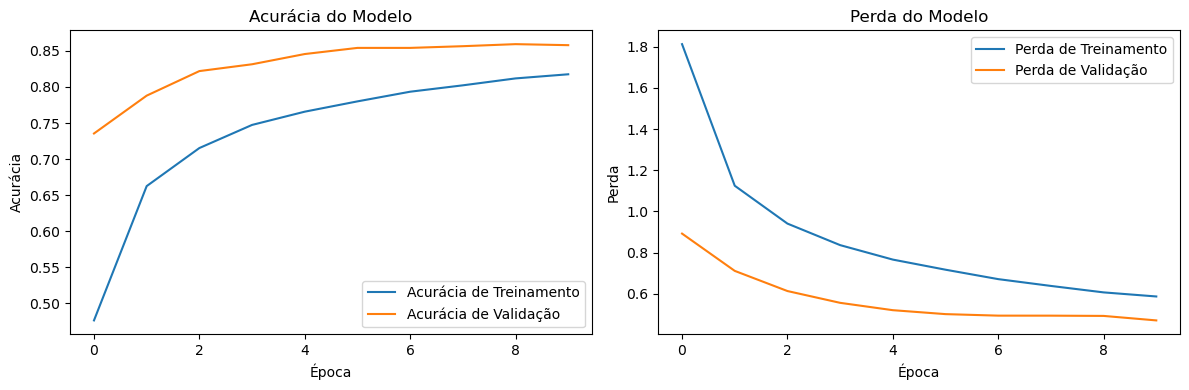

In [53]:
plot_history(history_spectrogram)

In [ ]:
specfic_audio_path = "yes.wav"

In [ ]:
specfic_audio = load_and_process_audio(specfic_audio_path)
specfic_spectrogram = espectrograma(specfic_audio.numpy())
specfic_audio_path = np.expand_dims(specfic_spectrogram, axis=0)

In [60]:
specfic_prediction= model_spectrogram.predict(specfic_audio_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


In [61]:
specfic_prediction

array([[1.62930999e-25, 5.18719165e-16, 3.07847294e-08, 2.41938170e-13,
        3.67650238e-04, 3.25402005e-13, 1.69126976e-10, 9.33135791e-10,
        8.13771869e-16, 1.87030021e-19, 1.94001581e-21, 1.28082912e-15,
        1.70536107e-09, 2.10854778e-10, 4.65616878e-08, 2.96819513e-11,
        6.95675624e-07, 9.77247322e-16, 2.27069187e-14, 2.40361953e-09,
        9.10790540e-12, 6.12011290e-20, 1.18371888e-16, 3.10375261e-13,
        7.87816687e-11, 1.11230136e-10, 6.86017393e-06, 6.96793274e-12,
        2.25783086e-14, 8.79115048e-17, 2.95064778e-10, 6.84314855e-13,
        1.52863153e-10, 4.00216732e-14, 9.99624729e-01, 7.71049669e-10]],
      dtype=float32)

In [64]:
specfic_prediction_label = np.argmax(specfic_prediction, axis=-1)[0]

In [65]:
label_encore.inverse_transform([specfic_prediction_label])[0]

'yes'

In [ ]:
model_spectrogram.save("model_spectrogram.keras")